# Example of integration with HyperSpy lazy signals

This notebook shows the several ways in which LiberTEM can integrate with Dask and by extension HyperSpy [lazy signals](http://hyperspy.org/hyperspy-doc/current/user_guide/big_data.html). In particular:

- how to apply a LiberTEM UDF to a HyperSpy lazy signal
- how to create a HyperSpy lazy signal from a LiberTEM DataSet
- how to create a HyperSpy lazy signal from a LiberTEM computation. 

This notebook requires the `hdbscan` extra and uses PyXem for scanning diffraction data support in HyperSpy.

Please note that these features are rather new and not well-tested yet (added in version 0.9.0). Bug reports and improvements are much appreciated!

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import dask
import hyperspy.api as hs
import pyxem
import matplotlib.pyplot as plt
# NBVAL_IGNORE_OUTPUT

In [3]:
from libertem.api import Context
from libertem.udf.sumsigudf import SumSigUDF
from libertem.contrib.daskadapter import make_dask_array
from libertem_blobfinder.common import correlation, patterns
from libertem_blobfinder.udf import refinement
import libertem.analysis.fullmatch as fm

As always, we start with a LiberTEM Context object to act as interface to Dask. Here we use the `make_with` convenience method to create a `Context` which will integrate with any existing Dask scheduler, such as might have been instantiated by HyperSpy or other upstream computation.

In [4]:
ctx = Context.make_with("dask-integration")

Alternatively, we could create and set a LiberTEM Dask scheduler as the default Dask scheduler using `ctx = Context.make_with("dask-make-default")`.

Unfortunately, the current BLO-file reader in HyperSpy is not fully compatible with the default distributed scheduler created by LiberTEM.

In [5]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/cachedata/users/clausen/libertem-test-data/")
path = os.path.join(data_base_path, "default.blo")

## From HyperSpy to LiberTEM

### Load data as HyperSpy lazy signal

First we demonstrate the normal HyperSpy lazy signal workflow, where the `.data` backing the Signal is in fact a `dask.array.Array` which will be evaluated only when passed to `dask.compute()`. In the case of reading data from file, the data can remain on disk until required, rather than being loaded into memory at the beginning.

In [6]:
lazy_4d = hs.load(path, lazy=True)
lazy_4d

<LazyDiffraction2D, title: , dimensions: (121, 90|144, 144)>

In [7]:
# NBVAL_IGNORE_OUTPUT
lazy_4d.data

dask.array<array, shape=(90, 121, 144, 144), dtype=uint8, chunksize=(45, 41, 144, 144), chunktype=numpy.ndarray>

[########################################] | 100% Completed |  0.2s


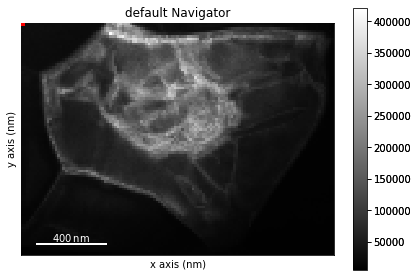

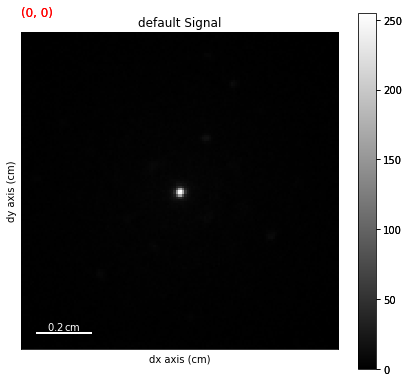

In [8]:
# NBVAL_IGNORE_OUTPUT
lazy_4d.plot()

### Load the HyperSpy lazy signal as a LiberTEM dataset

Starting with version 0.9.0, it is possible to load a `dask.array.Array` as a LiberTEM `Dataset`, allowing processing using the existing LiberTEM UDF interface. This can be achieved by loading the dask array using the `Context.load` method and the `"dask"` file type.

As before, no data is actually loaded into memory at this stage, it will only be read when computation is requested. When the data is eventually read, the HyperSpy BLO reader will be used by Dask to load the file.

In [9]:
dask_ds = ctx.load("dask", lazy_4d.data, sig_dims=2, min_size=64*2**20)

Due to differences in the design of Dask and LiberTEM, the `Dataset` must sometimes modify the array chunking (i.e. how the data is organised in memory), leading to the above warning. This does not modify the data itself in any way, it only changes how the computation will be split over parts of the full dataset.

We start by running some basic analyses on the dataset, loading a single diffraction frame with `create_pick_analysis` and summing over the signal dimensions with `SumSigUDF`. For both of these calls the data is loaded from disk at this point.

In [10]:
pick_a = ctx.create_pick_analysis(dataset=dask_ds, y=45, x=60)
pick_res = ctx.run(pick_a)

In [11]:
sum_res = ctx.run_udf(dataset=dask_ds, udf=SumSigUDF())

In [12]:
%%timeit
# NBVAL_SKIP
sum_res = ctx.run_udf(dataset=dask_ds, udf=SumSigUDF())

282 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


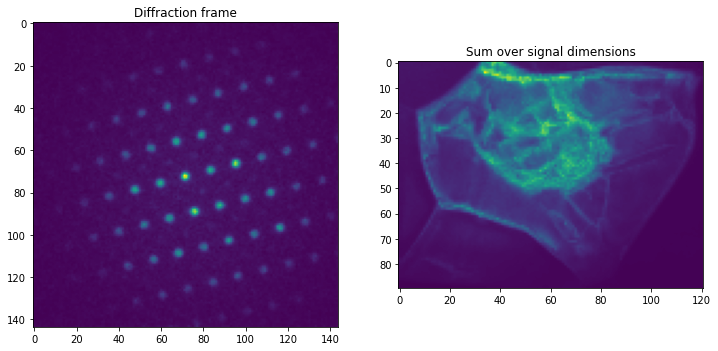

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(pick_res['intensity'].raw_data);
axes[0].set_title('Diffraction frame');
axes[1].imshow(sum_res['intensity'].data);
axes[1].set_title('Sum over signal dimensions');

## From LiberTEM to HyperSpy: Dataset

### Load data using LiberTEM

LiberTEM posesses its own BLO-file reader (here with auto-detection of filetype). First we run the same analyses as above to demonstrate their equivalency.

In [14]:
native_ds = ctx.load('auto', path)

In [15]:
sum_res_lt = ctx.run_udf(dataset=native_ds, udf=SumSigUDF())

In [16]:
%%timeit
# NBVAL_SKIP
ctx.run_udf(dataset=native_ds, udf=SumSigUDF())

310 ms ± 70.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
np.allclose(sum_res_lt['intensity'].data, sum_res['intensity'].data)

True

### Create dask array from LiberTEM dataset

Using the method `make_dask_array`, we can convert any LiberTEM dataset into a chunked `dask.array`, such as those used for backing a HyperSpy lazy signal.

In [18]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    dask_array, workers = make_dask_array(native_ds)

The `dask_array` is supplied with a dictionary of `workers`, which can be passed to `dask.compute()` at the moment of evaluation to ensure data locality, and avoid transferring chunks of the dataset between processes or over the network.

### Create lazy HyperSpy signal from Dask array

We now create a HyperSpy signal from this `dask_array`, with the aid of `pyxem` to maintain its metadata as a diffraction dataset.

In [19]:
libertem_4d = pyxem.signals.LazyDiffraction2D(dask_array)

This gives us access to the full range of HyperSpy interfaces on the LiberTEM dataset, such as `.plot()`.

[########################################] | 100% Completed |  0.8s


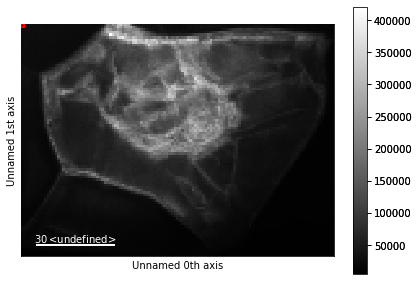

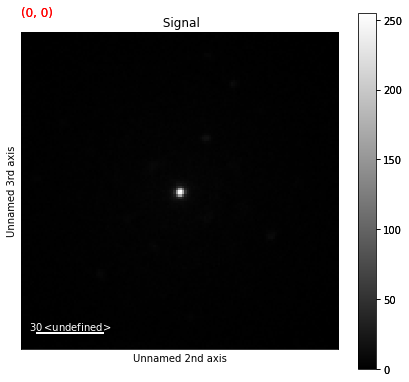

In [20]:
# NBVAL_IGNORE_OUTPUT
libertem_4d.plot()

## From LiberTEM to HyperSpy: UDF computation result

Starting with version 0.9.0, it is possible to obtain Dask arrays as output from LiberTEM UDF computations. This remains experimental and requires use of a dedicated LiberTEM `Context`. The computation is carried out relying on [Dask.delayed](https://docs.dask.org/en/stable/delayed.html), which allows us to run normal Python code, such as a UDF, within a Dask task graph.

As an example, this uses the LiberTEM blobfinder https://libertem.github.io/LiberTEM-blobfinder/ for diffraction disk finding and pattern matching.

### Setup the pattern analysis

To begin, we use the HyperSpy signal we created above and LiberTEM blobfinder to create a pattern analysis.

First a reference frame on which we make initial guesses of the peak positions and lattice vectors:

In [21]:
reference_frame = lazy_4d.data[50, 60].compute()

Note we must `.compute()` the frame because the HyperSpy signal is lazily evaluated.

We create a search pattern based on a disk radius measured in pixels:

In [22]:
r = 1.5
pattern = patterns.BackgroundSubtraction(radius=r)

We evaluate the initial peak positions in the reference frame using correlation with our search pattern:

In [23]:
peaks = correlation.get_peaks(sum_result=reference_frame, match_pattern=pattern, num_peaks=50)

We interpret the detected disks as a diffraction pattern (with principal vectors etc). using the `.full_match` method, this requires us to identify the transmitted beam position in pixels (the zero position):

In [24]:
zero = (71, 71)
matcher = fm.FullMatcher()
all_match = matcher.full_match(peaks, zero=zero)
match = all_match[0][0]

And finally we display the results on the reference frame:

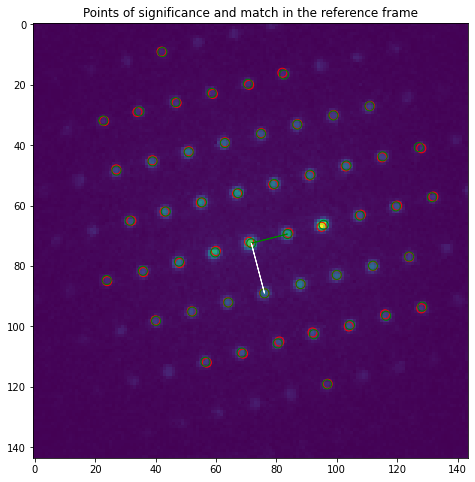

In [25]:
fig, axes = plt.subplots(figsize=(10, 8))
axes.imshow(reference_frame)
plt.title("Points of significance and match in the reference frame");

for p in np.flip(match.refineds, axis=1):
    axes.add_artist(plt.Circle(p, r, color="r", fill=False));
for p in np.flip(match.calculated_refineds, axis=1):
    axes.add_artist(plt.Circle(p, r, color="g", fill=False));
plt.arrow(*np.flip(match.zero), *(np.flip(match.a)), color='g');
plt.arrow(*np.flip(match.zero), *(np.flip(match.b)), color='w');

### Per-frame refinement of the parameters we found above

All of the above was setup for the analysis of the whole dataset based on the detected pattern. For this we will use the special Delayed context, though the same analysis would run with any of the LiberTEM executors.

In [26]:
delayed_ctx = Context.make_with('delayed')

In [27]:
%%time
refined, indices = refinement.run_refine(ctx=delayed_ctx,
                                         dataset=native_ds,
                                         zero=match.zero,
                                         a=match.a,
                                         b=match.b,
                                         matcher=matcher,
                                         match_pattern=pattern,
                                         indices=np.mgrid[-4:5, -4:5])
# NBVAL_IGNORE_OUTPUT

CPU times: user 16.3 ms, sys: 8.04 ms, total: 24.3 ms
Wall time: 23.3 ms


Note that the 'analysis' only takes a few milliseconds. As stated previously, the computation is specified lazily using a Dask task graph, so the actual work is only done when the result is requested; we have only told the system what we want to do in the future.

The same applies to any computation after the refinement step, such as computing the lattice vector lengths or ratio:

In [28]:
abs_a = np.sqrt(np.sum(refined['a'].delayed_data**2, axis=-1))
abs_b = np.sqrt(np.sum(refined['b'].delayed_data**2, axis=-1))
ratio = abs_a / abs_b

We can then wrap the result in a HyperSpy signal to benefit from the many methods and interfaces the library provides:

In [29]:
ratio_hs = hs.signals.Signal2D(ratio).as_lazy()

For demonstration, we can visualize the dask task graph, showing the computation that will be performed when requested:

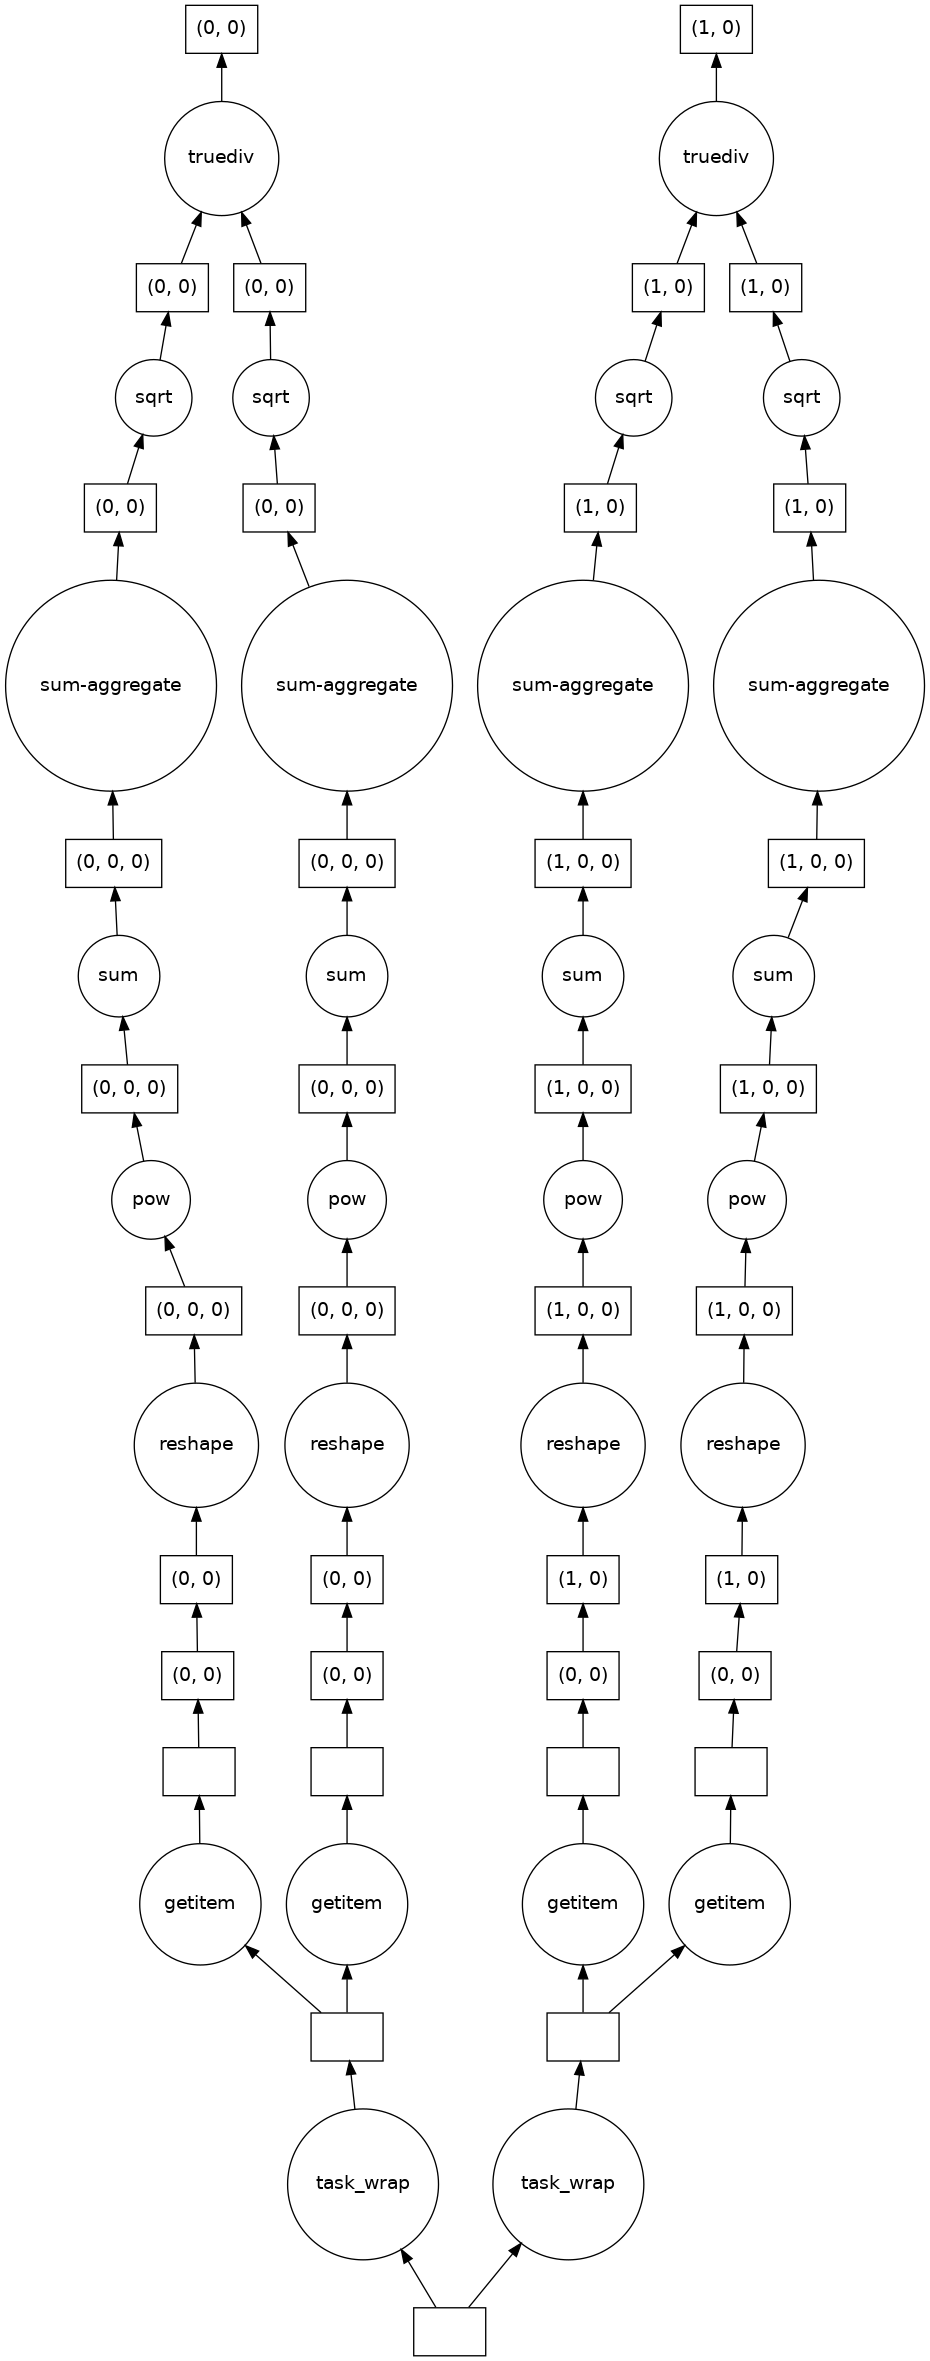

In [30]:
# NBVAL_SKIP
ratio_hs.data.visualize()

Finally, we plot the result, which automatically triggers the computation behind-the-scenes:

CPU times: user 22.5 s, sys: 2.25 s, total: 24.7 s
Wall time: 21 s


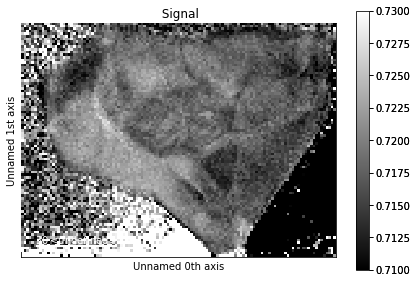

In [31]:
%time ratio_hs.plot(vmin=0.71, vmax=0.73)
# NBVAL_IGNORE_OUTPUT